Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


# Contents
- ## [Implementation](#mplementation)
 - ### [List of Files](#list-of-files)
 - ### [Utility to call gc](#gc)
 - ### [Selection of Columns](#select-columns)
 - ### [Function to compare the three selections of columns for a given dataset](#compare-fn)
 - ### [Load the datasets](#load-dataset)
 - ### [Select the datasets](#dataset-selection)
 - ### [Run all combinations of data](#dataset-selection)
- ## [Results](#results)
 - ### [Print the raw results](#raw-results)
 - ### [Sort by the improvement when using Fourier transforms over baseline](#sorted-fourier)\
 - ### [Measure improvement when only webp files are used](#webp-only)
 - ### [Measure improvement when webp files are not present](#no-webp)
 - ### [Measure improvement for balanced datasets](#balanced-dataset)
 - ### [Measure the improvement when all files are used](#full-dataset)
 


## Implementation <a class="anchor" id="implementation">
    
[top](#Contents)

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

from functools import lru_cache

import gc

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import glob

plt.rcParams["figure.figsize"] = (20,20)

### List of files <a class="anchor" id="list-of-files">

[top](#Contents)

In [2]:
!ls

expanded.plaintext.base32.csv.gz
expanded.pyencrypted_v1.b32.csv.gz
expanded.pyencrypted_v1.csv.gz
expanded.pyencrypted_v2.base32.csv.gz
expanded.pyencrypted_v2.csv.gz
iteration_2.010_compare_base32_alternate_encryption_scheme.ipynb
plaintext.base32.combined.csv.gz
plaintext.combined.csv.gz
plaintext.expanded.csv.gz


### Utility to call GC <a class="anchor" id="gc">
    
[top](#Contents)

In [3]:
def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)

### Selection of columns <a class="anchor" id="select-columns">
    
This function is used to select the columns.
There are three different configurations:
    
    1. Baseline - statistics like autocorrelation, shannon entropy, chi-square etc. are used
    
    2. Advanced - More statistics like moments, Tsallis and Renyi entropy, higher moments etc.
    
    3. Fourier - Some statistics of the Fourier Power Spectrum distribution
    
[top](#Contents)

In [4]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    return {\
        "baseline": baseline_columns,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
    }


### Function to compare the three selections of columns for a given dataset <a class="anchor" id="compare-fn">
    
For the three different sets of measurements described above, compare all the three sets for their f1 score
    
[top](#Contents)

In [5]:
def compare_feature_selections(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    columns_dict = get_columns(X)
    ret = dict()
    for name, collist in columns_dict.items():
        XX_train, XX_test = X_train[collist], X_test[collist]
        rfc = RandomForestClassifier(n_jobs=10, random_state=42)
        estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
        pipeline = Pipeline(estimators)
        pipeline.fit(XX_train, y_train)
        y_pred = pipeline.predict(XX_test)
        f1 = f1_score(y_test, y_pred)
        ret[f"{name}-f1_score"] = f1
    return ret

def compare_feature_selections_wrapper(data):
    X = data[[c for c in data.columns if "is_encrypted" != c]]
    y = data["is_encrypted"]
    return compare_feature_selections(X, y)

### Load the datasets <a class="anchor" id="load-dataset">

We don't want to load the datasets again and again, so we load them once.
The LRU cache ensures that the next time this is called, we don't load the datasets again.
    
[top](#Contents)

In [6]:
@lru_cache
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("*.csv.gz"):
        df = pd.read_csv(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

### Select the datasets <a class="anchor" id="dataset-selection">

Select the dataset, combine it, shuffle it and return
    
We used several schemes:
* Plaintext
  - The base plaintext dataset of around 50k files
  - Expanded dataset, where all files that were less than 1500 bytes were expanded by repeating the file
  - Base32 encoding of
   - original plaintext
   - expanded plaintext
* Encryption : We used two schemes for encruption
  - v1 : AES 256 encryption of the full file, again two varieties were used
    - Plain encryption
    - Encryption followed by base32 encoding
  - v2 : AES encryption of the file, the first and the last 128 bytes are not encrypted. Of the remaining file, every alternate 16 bytes are encrypted.
    - Plain encryption
    - encryption followed by base32 encoding
    
We select combinations of the above datasets
    
Furthermore, we add further combinations by including and excluding webp files, and including and excluding non-webp files.
    
[top](#Contents)

In [7]:
def get_dataset(\
               exclude_plaintext_nonbase32=False,
               exclude_plaintext_base32=False,
               exclude_encrypted_v1=False,
               exclude_encrypted_v2=False,
               exclude_encrypted_base32=False,
               exclude_encrypted_nonbase32=False,
               exclude_webp=False,
               exclude_nonwebp=False):
    description = {k:v for k,v in locals().items() if "exclude" in k}
    files = glob.glob("*.csv.gz")
    
    
    if exclude_plaintext_nonbase32:
        files = [f for f in files if \
                     "plaintext" not in f \
                     or "_base32" in f \
                     or "_b32" in f]
    if exclude_plaintext_base32:
        files = [f for f in files if\
                    "plaintext" not in f or \
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_v1:
        files = [f for f in files if\
                    "_v1" not in f or "encr" not in f]
    if exclude_encrypted_v2:
        files = [f for f in files if \
                    "_v2" not in f or "encr" not in f]
    if exclude_encrypted_base32:
        files = [ f for f in files if\
                    "encr" not in f or\
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_nonbase32:
        files = [f for f in files if \
                    "encr" not in f or \
                    "base32" in f or "b32" in f]
        
        
    encrypted_count = len([f for f in files if "encr" in f])
    non_encrypted_count = len([f for f in files if "encr" not in f])
    
    if 0 == encrypted_count or 0 == non_encrypted_count or 0 == len(files):
        return description, None, -1, -1
    
    all_dfs = list()
    all_loaded_datasets = load_datasets_once()
    for filename in files:
        all_dfs.append(all_loaded_datasets[filename])
    
    combined_df = pd.concat(all_dfs)
    
    if exclude_webp:
        combined_df = combined_df[combined_df["extended.extension"] != ".webp"]
    if exclude_nonwebp:
        combined_df = combined_df[combined_df["extended.extension"] == ".webp"]
        
    if len(combined_df) == 0:
        return description, None, -1, -1
    
        
    encrypt_count = len(combined_df[combined_df["is_encrypted"] == 1])
    nonencrypted_count = len(combined_df[combined_df["is_encrypted"] == 0])

    
    if 0 == len(combined_df) or 0 == encrypt_count or 0 == nonencrypted_count:
        return description, None, -1, -1
    
    return description, combined_df, encrypt_count, nonencrypted_count

### Run all combinations of data <a class="anchor" id="dataset-selection">

For all combinations of the datasets, compare the three classes (basic, advanced, and Fourier)
    
[top](#Contents)

In [8]:
all_results = []
count = 2
try:
    for a in [True, False]:
        for b in [True, False]:
            for c in [True, False]:
                for k in [True, False]:
                    for e in [True, False]:
                        for f in [True, False]:
                            for g in [True, False]:
                                for h in [True, False]:
                                    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
                                    if df is not None:
                                        result = compare_feature_selections_wrapper(df)
                                        call_gc()
                                        result = {**desc, **result}
                                        result["n_encrypted"] = ec
                                        result["n_non_encrypted"] = nec
                                        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
                                        all_results.append(result)

                                        """
                                        count -= 1
                                        if count == 0:
                                            # A non-standard way to break out of 
                                            # all nested loops
                                            raise Exception("breaking out")
                                        """
except Exception as e:
    print(e)

df_dict = {k:[] for k in all_results[0]}
for result in all_results:
    for k, v in result.items():
        df_dict[k].append(v)

df = pd.DataFrame(df_dict)
df["best_f1_score"] = df[[c for c in df.columns if "f1_score" in c]].max(axis=1)

df["improvement_in_advanced"] = df["advanced-f1_score"] - df["baseline-f1_score"]
df["improvement_in_fourier"] = df["fourier-f1_score"] - df["baseline-f1_score"]
df = df.sort_values(by="improvement_in_fourier", ascending=False)
    
                                

## Results <a class="anchor" id="results">
    
In this section, we present the results
    
[top](#Contents)

### Print the raw results <a class="anchor" id="raw-results">
    
[top](#Contents)

In [9]:
df

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,fourier-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier
37,False,False,False,True,True,False,False,True,0.690682,0.872136,0.886821,31625,126500,0.25,0.886821,0.181454,0.196140
10,False,True,False,True,True,False,False,True,0.703183,0.866977,0.883858,31625,63250,0.50,0.883858,0.163794,0.180675
43,False,False,False,True,False,False,False,True,0.656482,0.813560,0.825912,63250,126500,0.50,0.825912,0.157079,0.169431
40,False,False,False,True,False,True,False,True,0.617365,0.773569,0.777615,31625,126500,0.25,0.777615,0.156204,0.160250
31,False,False,True,False,False,True,False,True,0.545348,0.654401,0.680834,31625,126500,0.25,0.680834,0.109053,0.135486
34,False,False,True,False,False,False,False,True,0.623332,0.721805,0.735058,63250,126500,0.50,0.735058,0.098473,0.111726
1,False,True,True,False,True,False,False,True,0.676500,0.775050,0.781492,31625,63250,0.50,0.781492,0.098550,0.104992
32,False,False,True,False,False,True,False,False,0.715513,0.777573,0.819461,80853,323412,0.25,0.819461,0.062060,0.103948
35,False,False,True,False,False,False,False,False,0.768112,0.825482,0.868005,161706,323412,0.50,0.868005,0.057369,0.099893
28,False,False,True,False,True,False,False,True,0.684000,0.776319,0.782407,31625,126500,0.25,0.782407,0.092318,0.098407


In [10]:
df.to_csv("../comparison.csv")

In [25]:
df = df.sort_values(by="improvement_in_fourier", ascending=False)

### Sort by the improvement when using Fourier transforms over baseline <a class="anchor" id="sorted-fourier">

We also take a few other things:
* Room for improvement (1 - baseline score)
* How much of the room for improvement was filled by fourier transforms (percentage)
* Difference between F1 score with advanced and fourier
        
[top](#Contents)

In [39]:
df["improvement_in_advanced"] = df["advanced-f1_score"] - df["baseline-f1_score"]
df["room_for_improvement"] = 1.0 - df["baseline-f1_score"]
df["fourier_minus_advanced"] = df["fourier-f1_score"] - df["advanced-f1_score"]
df["percentage_of_room_filled"] = df["improvement_in_fourier"] * 100.0 / df["room_for_improvement"]
#df.sort_values(by="fourier_minus_advanced", ascending=False)
df

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,fourier-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,percentage_of_room_filled,fourier_minus_advanced
37,False,False,False,True,True,False,False,True,0.690682,0.872136,0.886821,31625,126500,0.25,0.886821,0.181454,0.196140,0.309318,63.410338,0.014686
10,False,True,False,True,True,False,False,True,0.703183,0.866977,0.883858,31625,63250,0.50,0.883858,0.163794,0.180675,0.296817,60.870864,0.016881
43,False,False,False,True,False,False,False,True,0.656482,0.813560,0.825912,63250,126500,0.50,0.825912,0.157079,0.169431,0.343518,49.322156,0.012352
40,False,False,False,True,False,True,False,True,0.617365,0.773569,0.777615,31625,126500,0.25,0.777615,0.156204,0.160250,0.382635,41.880608,0.004046
31,False,False,True,False,False,True,False,True,0.545348,0.654401,0.680834,31625,126500,0.25,0.680834,0.109053,0.135486,0.454652,29.800011,0.026434
34,False,False,True,False,False,False,False,True,0.623332,0.721805,0.735058,63250,126500,0.50,0.735058,0.098473,0.111726,0.376668,29.661656,0.013253
1,False,True,True,False,True,False,False,True,0.676500,0.775050,0.781492,31625,63250,0.50,0.781492,0.098550,0.104992,0.323500,32.455075,0.006442
32,False,False,True,False,False,True,False,False,0.715513,0.777573,0.819461,80853,323412,0.25,0.819461,0.062060,0.103948,0.284487,36.538765,0.041888
35,False,False,True,False,False,False,False,False,0.768112,0.825482,0.868005,161706,323412,0.50,0.868005,0.057369,0.099893,0.231888,43.078097,0.042524
28,False,False,True,False,True,False,False,True,0.684000,0.776319,0.782407,31625,126500,0.25,0.782407,0.092318,0.098407,0.316000,31.141413,0.006088


### Measure improvement when only webp files are used <a class="anchor" id="webp-only">

We want to measure this alone because in the literature, poor performance in webp files has been mentioned
    
[top](#Contents)

In [44]:
df[(df["exclude_webp"] == False) & (df["exclude_nonwebp"] == True)]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,fourier-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,percentage_of_room_filled,fourier_minus_advanced
37,False,False,False,True,True,False,False,True,0.690682,0.872136,0.886821,31625,126500,0.25,0.886821,0.181454,0.196140,0.309318,63.410338,0.014686
10,False,True,False,True,True,False,False,True,0.703183,0.866977,0.883858,31625,63250,0.50,0.883858,0.163794,0.180675,0.296817,60.870864,0.016881
43,False,False,False,True,False,False,False,True,0.656482,0.813560,0.825912,63250,126500,0.50,0.825912,0.157079,0.169431,0.343518,49.322156,0.012352
40,False,False,False,True,False,True,False,True,0.617365,0.773569,0.777615,31625,126500,0.25,0.777615,0.156204,0.160250,0.382635,41.880608,0.004046
31,False,False,True,False,False,True,False,True,0.545348,0.654401,0.680834,31625,126500,0.25,0.680834,0.109053,0.135486,0.454652,29.800011,0.026434
34,False,False,True,False,False,False,False,True,0.623332,0.721805,0.735058,63250,126500,0.50,0.735058,0.098473,0.111726,0.376668,29.661656,0.013253
1,False,True,True,False,True,False,False,True,0.676500,0.775050,0.781492,31625,63250,0.50,0.781492,0.098550,0.104992,0.323500,32.455075,0.006442
28,False,False,True,False,True,False,False,True,0.684000,0.776319,0.782407,31625,126500,0.25,0.782407,0.092318,0.098407,0.316000,31.141413,0.006088
16,False,True,False,True,False,False,False,True,0.857143,0.935900,0.944788,63250,63250,1.00,0.944788,0.078758,0.087645,0.142857,61.351650,0.008888
19,False,True,False,False,True,False,False,True,0.791431,0.863164,0.869495,63250,63250,1.00,0.869495,0.071733,0.078064,0.208569,37.428390,0.006331


### Measure improvement when webp files are not present <a class="anchor" id="no-webp">
    
[top](#Contents)

In [41]:
df[(df["exclude_webp"] == True) & (df["exclude_nonwebp"] == False)]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,fourier-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,percentage_of_room_filled,fourier_minus_advanced
30,False,False,True,False,False,True,True,False,0.828541,0.876089,0.922745,49228,196912,0.25,0.922745,0.047549,0.094204,0.171459,54.942423,0.046655
33,False,False,True,False,False,False,True,False,0.866051,0.904552,0.956035,98456,196912,0.50,0.956035,0.038501,0.089984,0.133949,67.177920,0.051483
0,False,True,True,False,True,False,True,False,0.903011,0.936882,0.989274,49228,98456,0.50,0.989274,0.033871,0.086263,0.096989,88.941403,0.052393
27,False,False,True,False,True,False,True,False,0.904989,0.934987,0.989254,49228,196912,0.25,0.989254,0.029998,0.084265,0.095011,88.690070,0.054268
45,False,False,False,False,True,False,True,False,0.950829,0.968286,0.994547,98456,196912,0.50,0.994547,0.017457,0.043719,0.049171,88.910936,0.026261
6,False,True,True,False,False,False,True,False,0.950388,0.967627,0.993917,98456,98456,1.00,0.993917,0.017239,0.043529,0.049612,87.738681,0.026290
18,False,True,False,False,True,False,True,False,0.951220,0.967449,0.994447,98456,98456,1.00,0.994447,0.016229,0.043227,0.048780,88.616283,0.026998
51,False,False,False,False,False,False,True,False,0.936347,0.955159,0.979468,196912,196912,1.00,0.979468,0.018812,0.043120,0.063653,67.743457,0.024309
48,False,False,False,False,False,True,True,False,0.920717,0.943055,0.963069,98456,196912,0.50,0.963069,0.022339,0.042353,0.079283,53.419324,0.020014
24,False,True,False,False,False,False,True,False,0.975411,0.984081,0.997408,196912,98456,2.00,0.997408,0.008670,0.021997,0.024589,89.457697,0.013327


### Measure improvement for balanced datasets <a class="anchor" id="balanced-dataset">

Most of our dataset selections are not balanced, and we didn't do anything to mitigate
unablanced datasets. This is because we are measuring the baseline and improvement on the
same dataset.
    
However, we will select those instances where the datasets were balanced to see if the
improvement is still significant in these instances.
    
[top](#Contents)

In [42]:

df[df["ratio_encrypt_nonencrypt"] == 1.0]

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,fourier-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,percentage_of_room_filled,fourier_minus_advanced
16,False,True,False,True,False,False,False,True,0.857143,0.935900,0.944788,63250,63250,1.0,0.944788,0.078758,0.087645,0.142857,61.351650,0.008888
19,False,True,False,False,True,False,False,True,0.791431,0.863164,0.869495,63250,63250,1.0,0.869495,0.071733,0.078064,0.208569,37.428390,0.006331
52,False,False,False,False,False,False,False,True,0.780966,0.842506,0.854287,126500,126500,1.0,0.854287,0.061540,0.073321,0.219034,33.474711,0.011781
53,False,False,False,False,False,False,False,False,0.885429,0.914270,0.933756,323412,323412,1.0,0.933756,0.028841,0.048327,0.114571,42.180668,0.019486
20,False,True,False,False,True,False,False,False,0.900294,0.927762,0.947397,161706,161706,1.0,0.947397,0.027468,0.047103,0.099706,47.242226,0.019635
8,False,True,True,False,False,False,False,False,0.913086,0.939108,0.957944,161706,161706,1.0,0.957944,0.026022,0.044858,0.086914,51.611826,0.018836
6,False,True,True,False,False,False,True,False,0.950388,0.967627,0.993917,98456,98456,1.0,0.993917,0.017239,0.043529,0.049612,87.738681,0.026290
18,False,True,False,False,True,False,True,False,0.951220,0.967449,0.994447,98456,98456,1.0,0.994447,0.016229,0.043227,0.048780,88.616283,0.026998
51,False,False,False,False,False,False,True,False,0.936347,0.955159,0.979468,196912,196912,1.0,0.979468,0.018812,0.043120,0.063653,67.743457,0.024309
7,False,True,True,False,False,False,False,True,0.860662,0.899484,0.902660,63250,63250,1.0,0.902660,0.038822,0.041998,0.139338,30.140884,0.003176


### Measure the improvement when all files are used <a class="anchor" id="full-dataset">

In most of our dataset selections, we excluded some data points based on our criteria.

In this, we measure the improvement when we use all data points
    
[top](#Contents)

In [43]:
# Measure everything for the full dataset
df2 = df
for colname in df2.columns:
    if "exclude" in colname:
        df2 = df2[df2[colname] == False]
df2

,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,advanced-f1_score,fourier-f1_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,percentage_of_room_filled,fourier_minus_advanced
53,False,False,False,False,False,False,False,False,0.885429,0.91427,0.933756,323412,323412,1.0,0.933756,0.028841,0.048327,0.114571,42.180668,0.019486


In [2]:
df[[c for c in df.columns if ("score" in c or "improvement" in c) and "room" not in c]].mean()

baseline-f1_score          0.872847
advanced-f1_score          0.915976
fourier-f1_score           0.930653
best_f1_score              0.930653
improvement_in_advanced    0.043129
improvement_in_fourier     0.057805
dtype: float64

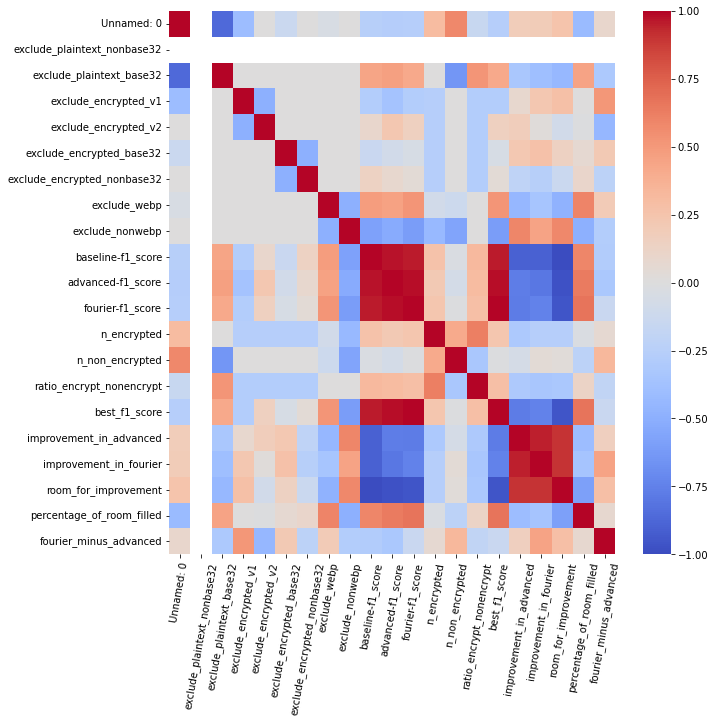

In [5]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
sns.heatmap(df.astype(float).corr(), cmap='coolwarm')
# print(df[df["baseline-f1_score"] > 0.9].astype(float))
_ = plt.xticks(rotation=80) 

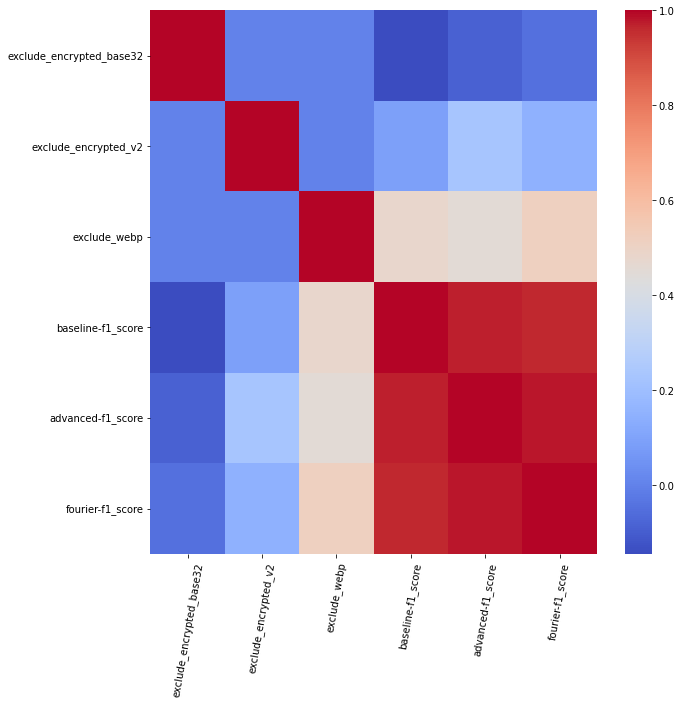

In [6]:
df1 = df[["exclude_encrypted_base32", "exclude_encrypted_v2", "exclude_webp", "baseline-f1_score", "advanced-f1_score", "fourier-f1_score"]]
sns.heatmap(df1.astype(float).corr(), cmap='coolwarm')
_ = plt.xticks(rotation=80) 